# Arm Control

In [1]:
import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.core.embodied_task import Measure
from habitat.core.registry import registry
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig
from habitat.config.default import get_agent_config
from habitat_sim.physics import JointMotorSettings, MotionType
from habitat.utils.visualizations.utils import (
    observations_to_image,
    overlay_frame,
)
from omegaconf import OmegaConf

import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
# os.chdir(dir_path)

%matplotlib widget

pybullet build time: Feb 16 2024 15:08:58


In [2]:
import os

# To use data in repo root
os.chdir("/home/junting/repo/habitat-lab")

## Defining agent configurations
We start by defining a configuration for each agent we want to add. Articulated agents are represented as any other articulated object, and are therefore defined via an URDF file. While this file is enough to represent the agent as an object, it doesn't include a way to easily set its base position, reset its joints, move a specific part or query other attributes.

To simplify this, we provide an abstraction, `ArticulatedAgent`, which will wrap habitat-sim's ManagedArticulatedObject class initialized from the URDF and provide functionalities that are commonly useful for agent control. You can view the different ArticulatedAgents (robots and humanoids) [here](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-lab/habitat/articulated_agents).

## Defining an environment
We will start by defining the environment class. A key difference is that now we also define actions that the environment will have

In [3]:

from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import (   
    ArmActionConfig,
    BaseVelocityActionConfig,
    BaseVelocityNonCylinderActionConfig,
    OracleNavActionConfig, 
    ActionConfig
)
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # Enable Horizon Based Ambient Occlusion (HBAO) to approximate shadows.
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True

    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
    sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]
    
    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_sim(agent_dict):
    # Start the scene config
    sim_cfg = make_sim_cfg(agent_dict)    
    cfg = OmegaConf.create(sim_cfg)
    
    # Create the scene
    sim = RearrangeSim(cfg)

    # This is needed to initialize the agents
    sim.agents_mgr.on_new_scene()

    # For this tutorial, we will also add an extra camera that will be used for third person recording.
    camera_sensor_spec = habitat_sim.CameraSensorSpec()
    camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    camera_sensor_spec.uuid = "scene_camera_rgb"

    # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
    sim.add_sensor(camera_sensor_spec, 0)

    return sim

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

In [4]:
# Define the agent configuration
spot_agent_config = AgentConfig()
spot_agent_config.articulated_agent_urdf = os.path.join(data_path, "robots/hab_spot_arm/urdf/hab_spot_arm.urdf")
spot_agent_config.articulated_agent_type = "SpotRobot"
spot_agent_config.ik_arm_urdf = os.path.join(data_path, "robots/hab_spot_arm/urdf/hab_spot_onlyarm_dae.urdf")

# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why we are giving the sensors these names
spot_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# Define the agent configuration
fetch_agent_config = AgentConfig()
fetch_agent_config.articulated_agent_urdf = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
fetch_agent_config.articulated_agent_type = "FetchRobot"
fetch_agent_config.ik_arm_urdf = os.path.join(data_path,"robots/hab_fetch/robots/fetch_onlyarm.urdf")
# Define sensors that will be attached to this agent, here a third_rgb sensor and a head_rgb.
# We will later talk about why we are giving the sensors these names
fetch_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}


# We create a dictionary with names of agents and their corresponding agent configuration
# agent_dict = {"main_agent": spot_agent_config}
agent_dict = {"main_agent": fetch_agent_config}


In [5]:
action_dict = {
    "arm_ee_action": ArmActionConfig(
        arm_controller="ArmEEAction",
        # grip_controller="MagicGraspAction",
        grip_controller="SuctionGraspAction",
        render_ee_target=True
    ),
    "base_velocity_non_cylinder_action": BaseVelocityNonCylinderActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", 
        spawn_max_dist_to_obj=1.0,
        motion_control="base_velocity_non_cylinder",
        navmesh_offset=[[0.0, 0.0], [0.25, 0.0], [-0.25, 0.0]]
    )
}
env = init_rearrange_env(agent_dict, action_dict)

2024-03-14 14:27:58,216 Initializing dataset RearrangeDataset-v0
2024-03-14 14:27:58,219 initializing sim RearrangeSim-v0


[14:27:58:322233]:[Error]:[Metadata] SceneDatasetAttributesManager.cpp(304)::validateMap : `semantic_scene_descriptor_instances` Value : `semantics/hssd-hab_semantic_lexicon.json` not found on disk as absolute path or relative to `data/hab3_bench_assets/hab3-hssd`
[14:27:58:396088]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[14:27:58:396314]:[Warning]:[Scene] SemanticScene.h(315)::checkFileExists : ::loadSemanticSceneDescriptor: Filesemantics/hssd-hab_semantic_lexicon.jsondoes not exist.  Aborting load.
[14:27:58:396324]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `semantics/hssd-hab_semantic_lexicon.json` nor constructed filename : `semanti

Renderer: NVIDIA GeForce RTX 3080/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 525.147.05
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


8:464460]:[Warning]:[Sim] Simulator.cpp(594)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


In [6]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id
# object_index = 0
# obj_id = env.sim.scene_obj_ids[object_index]
# obj_id = 103 # 002_master_chef_can
# first_object = rom.get_object_by_id(obj_id)
# first_object = rom.get_object_by_handle("004_sugar_box_:0000")
object_handle = "024_bowl_:0000"
first_object = rom.get_object_by_handle(object_handle)
object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)
# TODO: unoccluded object did not work
# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object
agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
# while agent_displ > 1e-9 or agent_rot > 1e-9:
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("oracle_coord_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
# current robot base position 
print("Current robot base position", env.sim.articulated_agent.base_pos)

# current end effector position
print("Current end effector position", env.sim.articulated_agent.ee_transform().translation)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,467]:
Bad inertia tensor properties, setting inertia to zero for link: r_gripper_finger_link
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,467]:
Bad inertia tensor properties, setting inertia to zero for link: l_gripper_finger_link
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,467]:
Bad inertia tensor properties, setting inertia to zero for link: r_gripper_finger_link
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,467]:
Bad inertia tensor properties, setting inertia to zero for link: l_gripper_finger_link
024_bowl_:0000 is in Vector(-6.55347, 0.94428, -5.24923)
Current robot base position Vector(-6.27777, 0.180179, -4.54218)
Current end effector position Vector(-6.25458, 1.1748, -5.21099)


In [7]:
# distance from robot to the object
print("Initial distance from robot to the object", dist_agent_object)

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
final_dist_agent_object = object_agent_vec.length()
print("Current distance from robot to the object", final_dist_agent_object)


Initial distance from robot to the object 2.963736057281494
Current distance from robot to the object 0.758903443813324


In [8]:
# rom.get_object_handle_by_id(10)

In [9]:
# rom.get_object_id_by_handle("024_bowl_:0000")

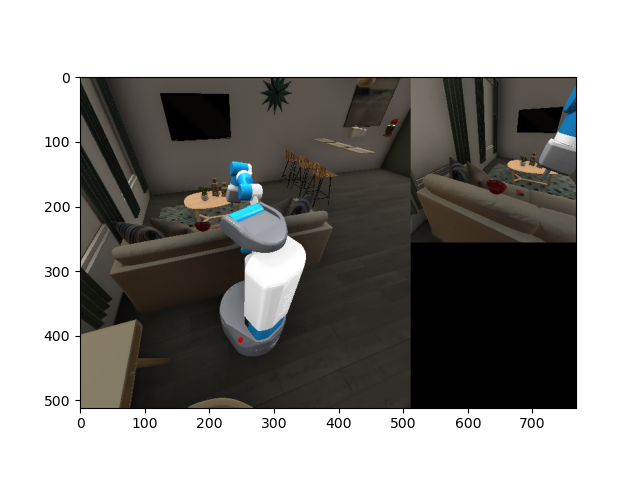

In [10]:
info = env.get_metrics()
render_obs = observations_to_image(observations[-1], info)
plt.figure()
plt.imshow(render_obs)

In [11]:

# reset observations 
observations = []

# Move the robot to the object
max_step = 300
step = 0

object_trans = first_object.translation
ee_displ = np.inf
prev_ee_pos = env._sim.articulated_agent.ee_transform().translation
is_grasped = False
while ee_displ > 1e-9 and step < max_step and is_grasped is False:
    # get the translation vector from current end effector to the object
    ee_pos = env._sim.articulated_agent.ee_transform().translation
    translation = object_trans - ee_pos 
    # distance = np.linalg.norm(translation)    
    translation_base = env._sim.articulated_agent.base_transformation.inverted().transform_vector(translation)
    # Pick up the object 
    action_dict = {
        "action": ("arm_ee_action"), 
        "action_args": {
            # "arm_action": np.array([0.0, 0.0, 0.1]),
            "arm_action": translation_base,
            "grip_action": 1
        }
    }
    
    observations.append(env.step(action_dict))  
    cur_ee_pos = env.sim.articulated_agent.ee_transform().translation
    ee_displ = np.linalg.norm(ee_pos - cur_ee_pos)
    is_grasped = env.sim.grasp_mgr.is_grasped
    step += 1

# raise the object    
step = 0
max_step = 30
while ee_displ > 1e-9 and step < max_step:

    # Pick up the object 
    action_dict = {
        "action": ("arm_ee_action"), 
        "action_args": {
            "arm_action": np.array([0.0, 0.0, 0.1]),
            # "arm_action": translation_base,
            "grip_action": 1
        }
    }
    
    observations.append(env.step(action_dict))  
    cur_ee_pos = env.sim.articulated_agent.ee_transform().translation
    ee_displ = np.linalg.norm(ee_pos - cur_ee_pos)
    step += 1

vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
    fps=10
)

Encoding the video: robot_tutorial_video.mp4 


In [12]:

vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
    fps=30
)

Encoding the video: robot_tutorial_video.mp4 


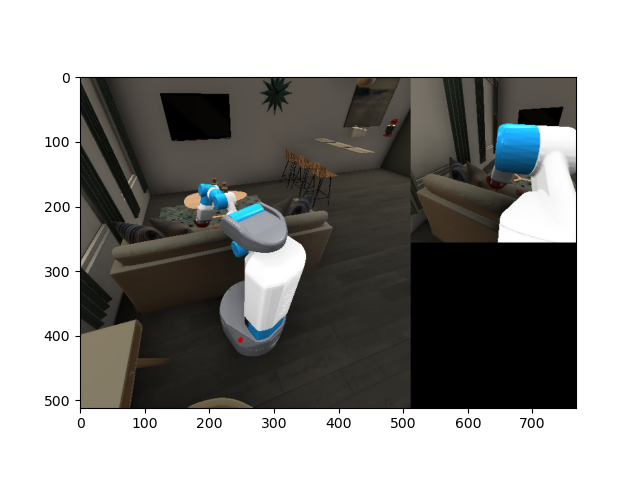

In [13]:
render_obs = observations_to_image(observations[-1], info)
plt.figure()
plt.imshow(render_obs)

In [14]:
# @registry.register_measure
# class DistanceToTargetObject(Measure):
#     """
#     Gets the Euclidean distance to the target object from the end-effector.
#     """

#     cls_uuid: str = "distance_to_object"

#     def __init__(self, sim, config, *args, **kwargs):
#         self._sim = sim
#         self._config = config
#         super().__init__(**kwargs)

#     @staticmethod
#     def _get_uuid(*args, **kwargs):
#         return DistanceToTargetObject.cls_uuid

#     def reset_metric(self, *args, episode, **kwargs):
#         self.update_metric(*args, episode=episode, **kwargs)

#     def update_metric(self, *args, task, episode, **kwargs):
#         ee_pos = self._sim.articulated_agent.ee_transform().translation

#         idxs, _ = self._sim.get_targets()
#         scene_pos = self._sim.get_scene_pos()[idxs[task.target_object_index]]

#         # Metric information is stored in the `self._metric` variable.
#         self._metric = np.linalg.norm(scene_pos - ee_pos, ord=2, axis=-1)